# External data exploration

In this notebook we will download two external datasets from:
 - IMDb (_title-basic.csv_)
 - TMDB (_tmdb.csv_)

The first one is directly available at [datasets.imdbws.com](https://datasets.imdbws.com/) while the latter was created by making calls to the API provided by [TMDB](https://www.themoviedb.org/documentation/api). In particular, we are interest on gather the runtime of each film.

### Imports

In [1]:
import os

import pandas as pd
import numpy as np

from src.data.acquisition import retrieve_imdb, retrieve_tmdb
from src.utils.const import DATA_DIR, IMDB_URL, EXTERNAL_IMDB_CSV_NAMES, EXTERNAL_TMDB_CSV_NAMES
from src.visualization.visualize import histplot

### Useful path to data

In [2]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
RAW_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'raw')
EXTERNAL_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'external')
INTERIM_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'interim')

## Data Acquisition

As we have seen in the previous notebook, the download of the first dataset occurs with the same pattern using the function `retrieve_idmb(...) -> bool`. It downloads the _.gz_ archive and decompress it inside the data/external folder.

In [3]:
if not retrieve_imdb(IMDB_URL, EXTERNAL_DIR, EXTERNAL_IMDB_CSV_NAMES):
    pass

Some external IMDB data missing, start download from https://datasets.imdbws.com
title.basics.tsv.gz: 154608KB [00:08, 18027.63KB/s]                            
Decompression...
Following data saved:
	- title-basics.csv
------------------------------


With the second dataset, it is possible to proceed in two ways:
- create DataFrame with API calls and specified features
- download the uploaded csv file in the GitHub repository [release](https://github.com/prushh/movie-lens-mlp/releases/tag/api-dataset)

If API call method is chosen (`USE_API` flag in `const.py`), the links' dataset is needed to retrieve each single film using the __tmdbId__.

In [4]:
# Retrieve TMDB dataset by API requests, links DataFrame is needed for tmdbId feature
links = pd.read_csv(
    os.path.join(RAW_DIR, 'links.csv'),
    encoding='utf-8',
    usecols=['movieId', 'tmdbId'],
    dtype={'movieId': 'int32', 'tmdbId': 'float32'}
)

# Specify features to retrieve from https://developers.themoviedb.org/3/movies/get-movie-details
features = {'imdb_id', 'budget', 'revenue', 'adult', 'runtime'}
if not retrieve_tmdb(links, EXTERNAL_DIR, EXTERNAL_TMDB_CSV_NAMES, features):
    pass

Some external TMDB data missing, download dataset from https://github.com/prushh/movie-lens-mlp/releases/download/api-dataset
Following data saved:
	- tmdb.csv
------------------------------


In particular from these datasets we are interested to gather the runtime of each film, for this reason some features will be discarded at priori.

## title-basics.csv (IMDb)

Title-basics is one of the many dataset that imdb let us available. As we said before, the only information that we take are the __runtime__ and the __tconst__.

In [5]:
imdb = pd.read_csv(
    os.path.join(EXTERNAL_DIR, 'title-basics.csv'),
    encoding='utf-8',
    low_memory=False
)

imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055571 entries, 0 to 9055570
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 621.8+ MB


In [6]:
print(f'IMDb dimensionality: {imdb.shape}')

IMDb dimensionality: (9055571, 9)


### Data Pre-processing / Cleaning

In [7]:
imdb = imdb[['tconst', 'runtimeMinutes']].astype({'tconst': 'string'})
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055571 entries, 0 to 9055570
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          string
 1   runtimeMinutes  object
dtypes: object(1), string(1)
memory usage: 138.2+ MB


The cardinality of this dataset is bigger than ours. From the IMDb dataset we have the data of all the films that are stored inside IMDb's database. For this reason, in the next steps we will let only the samples that represent a film on the MovieLens dataset.

In [8]:
imdb.head(20)

,tconst,runtimeMinutes
0,tt0000001,1
1,tt0000002,5
2,tt0000003,4
3,tt0000004,12
4,tt0000005,1
5,tt0000006,1
6,tt0000007,1
7,tt0000008,1
8,tt0000009,40
9,tt0000010,1


### Manage invalid values

We are now looking for all the rows that contains an invalid runtime in order to replace these values with NaN. For example, in the previous output we have at index 18, a runtimeMinutes that contains '\N'.

In [9]:
imdb[imdb['runtimeMinutes'].str.contains('[\\]*[a-zA-Z|\\-]+') == True].shape

(6616388, 2)

Now we've founded a way to select these rows, we can replace these invalid values with NaN.

In [10]:
imdb = (imdb
        .replace(regex={'runtimeMinutes': '[\\]*[a-zA-Z|\\-]+'}, value={'runtimeMinutes': np.nan})
        .rename(columns={'runtimeMinutes': 'runtime'})
        .astype({'runtime': 'float32'}))

imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055571 entries, 0 to 9055570
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   tconst   string 
 1   runtime  float32
dtypes: float32(1), string(1)
memory usage: 103.6 MB


### Summary

In [11]:
# Read
imdb = pd.read_csv(
    os.path.join(EXTERNAL_DIR, 'title-basics.csv'),
    encoding='utf-8',
    usecols=['tconst', 'runtimeMinutes'],
    dtype={'tconst': 'string'}
)

# Pre-processing & Cleaning
imdb = (imdb
        .replace(regex={'runtimeMinutes': '[\\]*[a-zA-Z|\\-]+'}, value={'runtimeMinutes': np.nan})
        .rename(columns={'runtimeMinutes': 'runtime'})
        .astype({'runtime': 'float32'}))

# Saving
imdb.to_parquet(os.path.join(INTERIM_DIR, 'title-basics.parquet'))

imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055571 entries, 0 to 9055570
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   tconst   string 
 1   runtime  float32
dtypes: float32(1), string(1)
memory usage: 103.6 MB


## tmdb.csv (TMDB)

In order to gather some information from TMDB, we made a query for each film of the movies' dataset to the TMDB database through its API. We only downloaded the information about the films that are contained in the movies' dataset. Since we are interested to know the run time of the film, we used only this feature plus the ones that are needed to identify the movie.

In [12]:
# Read
tmdb = pd.read_csv(
    os.path.join(EXTERNAL_DIR, 'tmdb.csv'),
    encoding='utf-8',
    usecols=['movieId', 'tmdbId', 'imdb_id', 'runtime'],
    dtype={'movieId': 'int32', 'imdb_id': 'string', 'tmdbId': 'float32', 'runtime': 'float32'}
)

tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int32  
 1   tmdbId   57917 non-null  float32
 2   runtime  57110 non-null  float32
 3   imdb_id  57156 non-null  string 
dtypes: float32(2), int32(1), string(1)
memory usage: 1.1 MB


## Merge TMDB and IMDb

Finally, we can throw away all the rows that doesn't regard our dataset. This is done merging the IDMb dataset with the TMDB one, that contains only the rows that came from the movies' dataset.

In [13]:
tmdb_imdb = tmdb.merge(imdb, how='left', left_on='imdb_id', right_on='tconst')

### Data Cleaning

#### Choose a runtime that is not NaN or 0

Due to the fact that the execution times come from two different sources, after merging the two datasets we can choose the execution time that is not 0 or NaN.

In [14]:
def extract_correct_runtime(df: pd.DataFrame) -> pd.DataFrame:
    df['runtime'] = df['runtime_x'].mask((df['runtime_x'].isna()) | (df['runtime_x'] == 0), df['runtime_y'])
    return df

In [15]:
tmdb_imdb = tmdb_imdb.pipe(extract_correct_runtime)

#### Checking NaN values

In [16]:
tmdb_imdb[tmdb_imdb['runtime'].isna()].shape

(971, 7)

Since we still have some NaN values on the runtime feature, we need to understand with which value we can replace the NaN values.

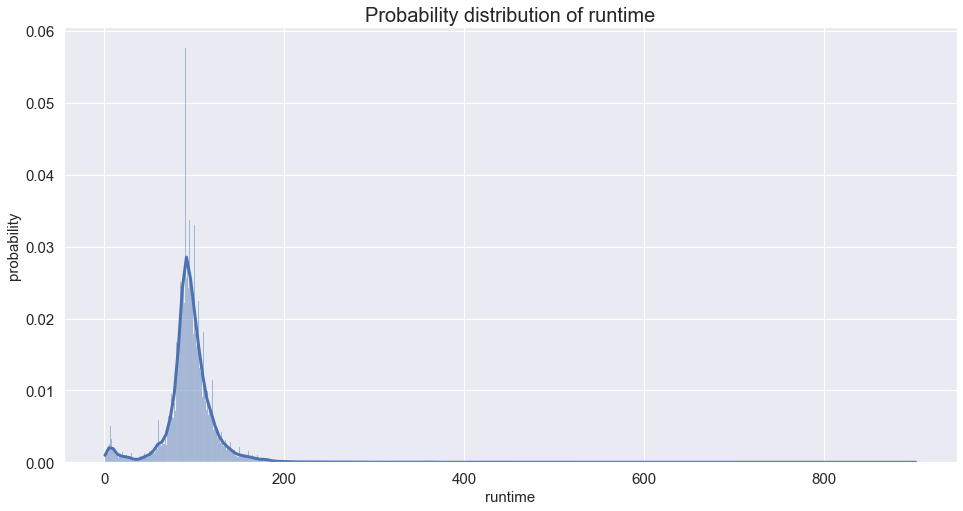

In [17]:
histplot(tmdb_imdb['runtime'],
         title='Probability distribution of runtime',
         xlabel='runtime',
         ylabel='probability',
         stat='probability',
         discrete=True,
         kde=True)

The runtime of the films has a skewed distribution. For this reason, we replace the NaN values with the median.

In [18]:
# Cleaning
tmdb_imdb = (tmdb_imdb
        .fillna({'runtime': tmdb_imdb['runtime'].median()})
        .drop(columns=['tmdbId', 'imdb_id', 'tconst', 'runtime_x', 'runtime_y']))

tmdb_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int32  
 1   runtime  58098 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 907.8 KB


#### Summary

In [19]:
# Merge
tmdb_imdb = tmdb.merge(imdb, how='left', left_on='imdb_id', right_on='tconst')

# Pre-processing & Cleaning
tmdb_imdb = (tmdb_imdb
        .pipe(extract_correct_runtime)
        .fillna({'runtime': tmdb_imdb['runtime'].median()})
        .drop(columns=['tmdbId', 'imdb_id', 'tconst', 'runtime_x', 'runtime_y']))

# Saving
tmdb_imdb.to_parquet(os.path.join(INTERIM_DIR, 'tmdb.parquet'))

tmdb_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int32  
 1   runtime  58098 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 907.8 KB
